In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torch.utils.data import random_split

In [2]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())


Extracting data/cifar-10-python.tar.gz to data/


In [30]:
torch.manual_seed(45)
val_size = 5000
train_size = len(dataset) - val_size

In [5]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [31]:
batch_size=130

In [7]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [32]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [33]:
class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # This generates the predictions
        loss = F.cross_entropy(out, labels) # This calculates the loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # This generates the predictions
        loss = F.cross_entropy(out, labels)   # This calculates the loss
        acc = accuracy(out, labels)           # This calculate the accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # This combines the losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # This combines the accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [10]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [35]:
input_size = 3*32*32
output_size = 10

In [16]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [17]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [34]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [37]:
class CIFAR10Model(ImageClassification):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, output_size)
        
    def forward(self, xb):
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        return out

In [38]:
model = to_device(CIFAR10Model(), device)

In [22]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.10375688970088959, 'val_loss': 2.3032045364379883}]

In [23]:
history += fit(10, 1e-1, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.9244, val_acc: 0.2907
Epoch [1], val_loss: 1.7314, val_acc: 0.3756
Epoch [2], val_loss: 1.6982, val_acc: 0.3953
Epoch [3], val_loss: 1.9746, val_acc: 0.3294
Epoch [4], val_loss: 1.7054, val_acc: 0.3983
Epoch [5], val_loss: 1.6199, val_acc: 0.4163
Epoch [6], val_loss: 1.6345, val_acc: 0.4072
Epoch [7], val_loss: 1.6089, val_acc: 0.4280
Epoch [8], val_loss: 1.6275, val_acc: 0.4172
Epoch [9], val_loss: 1.5325, val_acc: 0.4577


In [24]:
history += fit(10, 1e-2, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.4268, val_acc: 0.4950
Epoch [1], val_loss: 1.4212, val_acc: 0.4945
Epoch [2], val_loss: 1.4218, val_acc: 0.4983
Epoch [3], val_loss: 1.4137, val_acc: 0.5010
Epoch [4], val_loss: 1.4149, val_acc: 0.5010
Epoch [5], val_loss: 1.4134, val_acc: 0.4990
Epoch [6], val_loss: 1.4108, val_acc: 0.4953
Epoch [7], val_loss: 1.4093, val_acc: 0.5019
Epoch [8], val_loss: 1.4057, val_acc: 0.5031
Epoch [9], val_loss: 1.4015, val_acc: 0.5031


In [25]:
history += fit(10, 1e-3, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.3947, val_acc: 0.5050
Epoch [1], val_loss: 1.3944, val_acc: 0.5083
Epoch [2], val_loss: 1.3941, val_acc: 0.5070
Epoch [3], val_loss: 1.3931, val_acc: 0.5081
Epoch [4], val_loss: 1.3936, val_acc: 0.5075
Epoch [5], val_loss: 1.3927, val_acc: 0.5083
Epoch [6], val_loss: 1.3927, val_acc: 0.5081
Epoch [7], val_loss: 1.3928, val_acc: 0.5087
Epoch [8], val_loss: 1.3918, val_acc: 0.5095
Epoch [9], val_loss: 1.3919, val_acc: 0.5068


In [26]:
history += fit(10, 1e-4, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 1.3916, val_acc: 0.5081
Epoch [1], val_loss: 1.3915, val_acc: 0.5085
Epoch [2], val_loss: 1.3914, val_acc: 0.5087
Epoch [3], val_loss: 1.3914, val_acc: 0.5085
Epoch [4], val_loss: 1.3914, val_acc: 0.5081
Epoch [5], val_loss: 1.3913, val_acc: 0.5087
Epoch [6], val_loss: 1.3913, val_acc: 0.5081
Epoch [7], val_loss: 1.3912, val_acc: 0.5081
Epoch [8], val_loss: 1.3912, val_acc: 0.5089
Epoch [9], val_loss: 1.3912, val_acc: 0.5089


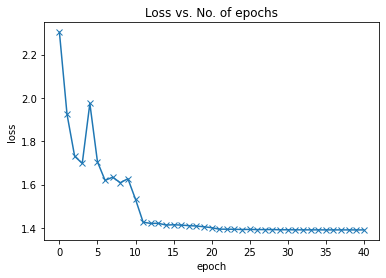

In [27]:
plot_losses(history)

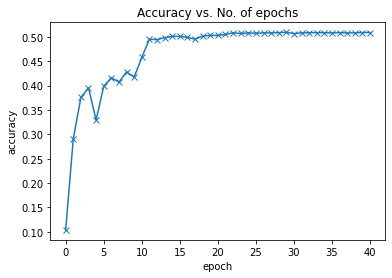

In [28]:
plot_accuracies(history)

In [29]:
evaluate(model, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.52001953125, 'val_loss': 1.350946068763733}

Here, I got around 52% accuracy. 

Citations:
https://www.analyticsvidhya.com/blog/2019/01/build-image-classification-model-10-minutes/

https://medium.com/@tifa2up/image-classification-using-deep-neural-networks-a-beginner-friendly-approach-using-tensorflow-94b0a090ccd4

https://www.pyimagesearch.com/2017/12/11/image-classification-with-keras-and-deep-learning/